In [4]:
# ============================================================
# EX04: Implementation of Transfer Learning using VGG-19
# ============================================================

# Install required libraries
!pip install torchsummary -q

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchsummary import summary

In [6]:

# ============================================================
# Step 1: Load and Preprocess Data
# ============================================================

# Unzip the dataset
!unzip -qq ./chip_data.zip -d data

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:

# Load dataset
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset  = datasets.ImageFolder(root=f"{dataset_path}/test",  transform=transform)

print(f"Classes: {train_dataset.classes}")
print(f"Total training samples : {len(train_dataset)}")
print(f"Total testing  samples : {len(test_dataset)}")

first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Classes: ['defect', 'notdefect']
Total training samples : 172
Total testing  samples : 121
Shape of the first image: torch.Size([3, 224, 224])


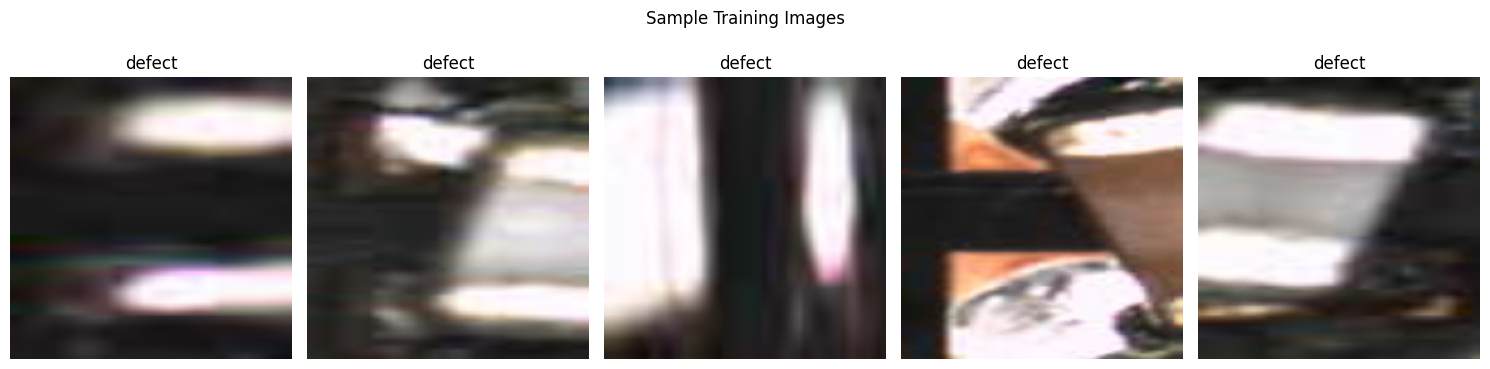

In [8]:

# ============================================================
# Visualise sample images
# ============================================================

def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
    for i in range(num_images):
        image, label = dataset[i]
        # Undo normalisation for display
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        image = image * std + mean
        image = image.permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.suptitle("Sample Training Images")
    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset)

In [9]:

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


In [10]:

# ============================================================
# Step 2: Load Pretrained VGG-19 and Modify for Transfer Learning
# ============================================================

# Load pre-trained VGG-19
model = models.vgg19(pretrained=True)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Print original model summary
summary(model, input_size=(3, 224, 224))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 67.5MB/s]


Using device: cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14 

In [11]:

# ============================================================
# Modify the final fully connected layer
# ============================================================

num_classes = len(train_dataset.classes)  # number of output classes

# Replace the last layer of the classifier
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

# Move updated model to device
model = model.to(device)

# Print updated model summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [12]:

# ============================================================
# Freeze all feature extractor layers (train only classifier)
# ============================================================

for param in model.features.parameters():
    param.requires_grad = False

In [13]:

# ============================================================
# Loss function and Optimizer
# ============================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

Epoch [1/5]  Train Loss: 0.8113  Val Loss: 0.1665
Epoch [2/5]  Train Loss: 0.2327  Val Loss: 0.1332
Epoch [3/5]  Train Loss: 0.0927  Val Loss: 0.6593
Epoch [4/5]  Train Loss: 0.0639  Val Loss: 0.2199
Epoch [5/5]  Train Loss: 0.0014  Val Loss: 0.7675
Name: Ramitha Chowdary S
Register Number: 212224240130


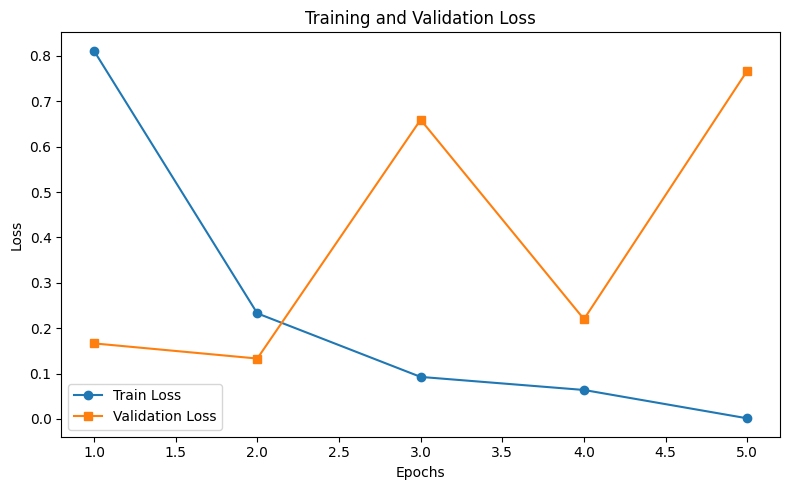

In [14]:

# ============================================================
# Step 3: Train the Model
# ============================================================

def train_model(model, train_loader, test_loader, num_epochs=5):
    train_losses = []
    val_losses   = []

    for epoch in range(num_epochs):
        # ----- Training -----
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # ----- Validation -----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {train_losses[-1]:.4f}  "
              f"Val Loss: {val_losses[-1]:.4f}")

    # Plot
    print("Name: Ramitha Chowdary S")
    print("Register Number: 212224240130")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss',      marker='o')
    plt.plot(range(1, num_epochs+1), val_losses,   label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_losses, val_losses

# Run training
train_losses, val_losses = train_model(model, train_loader, test_loader, num_epochs=5)



Test Accuracy: 0.9421
Name: Ramitha Chowdary S
Register Number: 212224240130


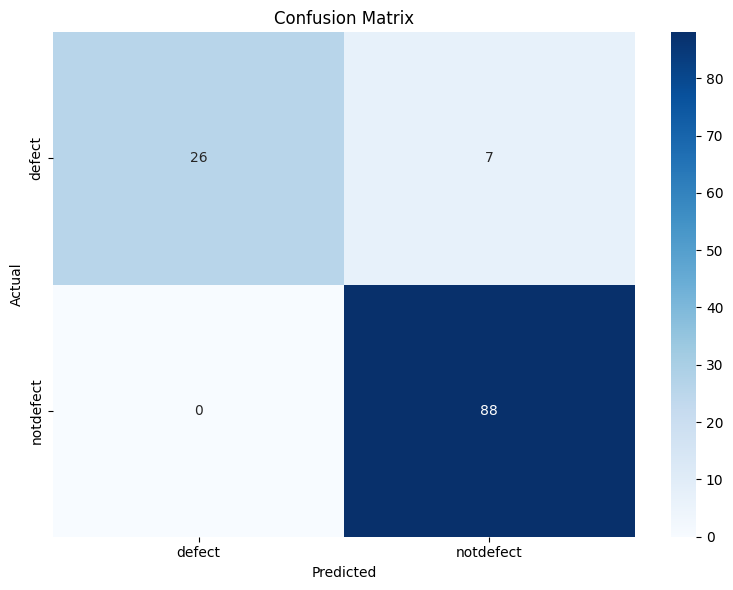

Name: Ramitha Chowdary S
Register Number: 212224240130

Classification Report:
              precision    recall  f1-score   support

      defect       1.00      0.79      0.88        33
   notdefect       0.93      1.00      0.96        88

    accuracy                           0.94       121
   macro avg       0.96      0.89      0.92       121
weighted avg       0.95      0.94      0.94       121



In [15]:
# ============================================================
# Step 4: Test the Model — Accuracy, Confusion Matrix, Report
# ============================================================

def test_model(model, test_loader):
    model.eval()
    correct    = 0
    total      = 0
    all_preds  = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name: Ramitha Chowdary S")
    print("Register Number: 212224240130")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("Name: Ramitha Chowdary S")
    print("Register Number: 212224240130")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=train_dataset.classes))

test_model(model, test_loader)

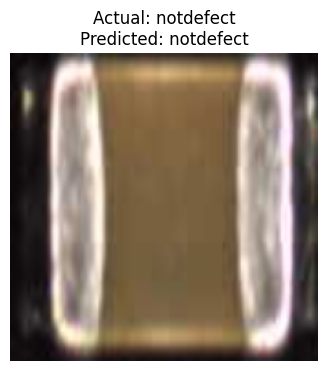

Actual: notdefect, Predicted: notdefect


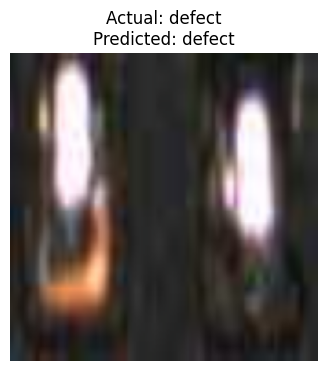

Actual: defect, Predicted: defect


In [16]:

# ============================================================
# Step 5: Predict on a Single Image
# ============================================================

def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]

    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted = predicted.item()

    class_names = dataset.classes

    # Undo normalisation for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_display = image * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    plt.figure(figsize=(4, 4))
    plt.imshow(img_display)
    plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[predicted]}")
    plt.axis("off")
    plt.show()

    print(f"Actual: {class_names[label]}, Predicted: {class_names[predicted]}")

# Example predictions
predict_image(model, image_index=55, dataset=test_dataset)
predict_image(model, image_index=25, dataset=test_dataset)